## Introduction

We illustrate the use of sensitivity analysis on the famous Lalonde data set. There are basically three different samples, one *experimental* and two *non-experimental* subsets. The samples have previously been used for sensitivity analysis, for example in Imbens (2003) and, more recently, in [Veitch and Zaveri (2020)](https://proceedings.neurips.cc/paper/2020/hash/7d265aa7147bd3913fb84c7963a209d1-Abstract.html).

A nice feature about the Lalonde data set is that makes it possible to compare the results from an experimental setting to an observational setting. Hence, we can compare the robustness of the results from an observational causal study to an experimental study, which is very unlikely affected by unobserved confounding. In this notebook, we basically replicate the sensitivity analysis in Imbens (2003) and [Veitch and Zaveri (2020)](https://proceedings.neurips.cc/paper/2020/hash/7d265aa7147bd3913fb84c7963a209d1-Abstract.html). A very nice notebook on the Lalonde data is also provided by [Yiqing Xu](https://yiqingxu.org/tutorials/lalonde/). 

The goal of the causal analysis is the evaluation of the *National Supported Work (NSW)* Demonstration, which is a labor market training program in the US. The program provides work experience for a period of up to 18 months to individuals with economic and social problems, with the aim to increase their labor market performance (for further empirical analyis of the data, see Chapter 4 of Huber (2023), for example).

## Data

We organize our analysis along the lines of Imbens (2003) and [Veitch and Zaveri (2020)](https://proceedings.neurips.cc/paper/2020/hash/7d265aa7147bd3913fb84c7963a209d1-Abstract.html) who consider (among others) two different sample specifications:

1. *Experimental Sample* - treated and control units randomly selected from the original experimental sample
2. *Lalonde Restricted Observational Sample* - selected sample of treated (148/185) and untreated (242/2490) units with individual earnings in 1975 and 1975 below $\$5000$.
3. *Lalonde Unrestriced Observational Sample* - treated from experimental sample and controls from full set of PSID observations.

The original data files are available from the supplemental material of [Veitch and Zaveri (2020)](https://proceedings.neurips.cc/paper/2020/hash/7d265aa7147bd3913fb84c7963a209d1-Abstract.html).

The data set contains nine covariates

* married
* age
* indicators for black and Hispanic,
* years of education
* (real) earnings in 1974 and 1975,
* and indicators for positive earnings in 1974 and 1975

and the outcome (earnings in 1978). The treatment variable is an indicator for participation in the job training program.

### 1. Experimental Sample

In [1]:
import pandas as pd

lalonde_exp = pd.read_csv('https://trainings.doubleml.org/datasets/imbens1.csv')
lalonde_exp.shape

c:\Users\bachp\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


(445, 11)

### 2. Restricted Sample

In [2]:
lalonde_restricted = pd.read_csv('https://trainings.doubleml.org/datasets/imbens4.csv')
lalonde_restricted.shape

(390, 11)

### 3. Unrestricted Sample

In [3]:
lalonde_nonexp = pd.read_csv('https://trainings.doubleml.org/datasets/imbens2.csv')
lalonde_nonexp.shape

(2675, 11)

We will start estimating the causal effect of NSW based on the observational sample first. To address selection-into-treatment mechanisms that would invalidate the unconfoundedness assumption, we perform a sensitivity analysis based on the observational samples. We will then re-examine the analysis based on the experimental sample and then see to what extent can be replicated using a restricted observational sample.

### Brief Summary Statistics

We mainly consider past earnings as a benchmark variable. To see the difference across the experimental and non-experimental samples, we plot the distribution of past earnings for the treated and control units.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
colors = sns.color_palette()
plt.rcParams['figure.figsize'] = 6., 4
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'axes.spines.top': False,
                            'axes.spines.bottom': False,
                            'axes.spines.left': False,
                            'axes.spines.right': False})

treatment
0.0    Axes(0.125,0.11;0.775x0.77)
1.0    Axes(0.125,0.11;0.775x0.77)
Name: RE75, dtype: object

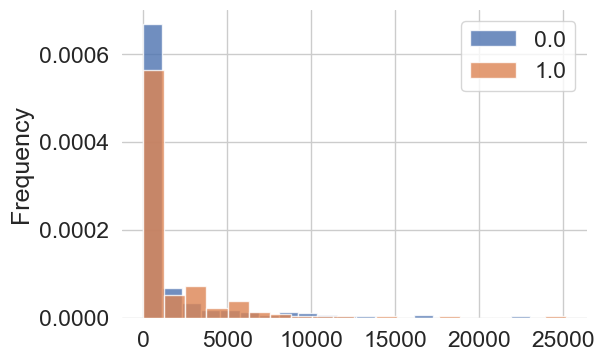

In [5]:
# Experimental sample
lalonde_exp.groupby('treatment')['RE75'].plot.hist(bins = 20, alpha = 0.8, density = True, legend = True)

treatment
0.0    Axes(0.125,0.11;0.775x0.77)
1.0    Axes(0.125,0.11;0.775x0.77)
Name: RE75, dtype: object

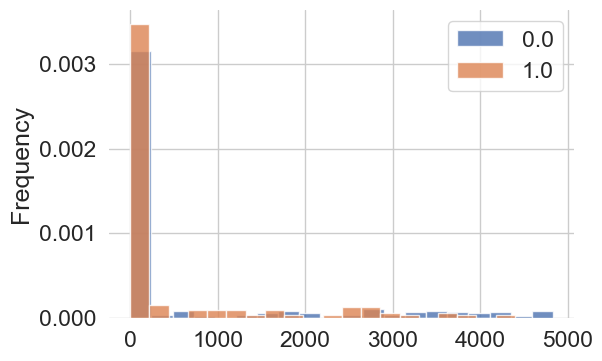

In [6]:
# Experimental sample
lalonde_restricted.groupby('treatment')['RE75'].plot.hist(bins = 20, alpha = 0.8, density = True, legend = True)

treatment
0.0    Axes(0.125,0.11;0.775x0.77)
1.0    Axes(0.125,0.11;0.775x0.77)
Name: RE75, dtype: object

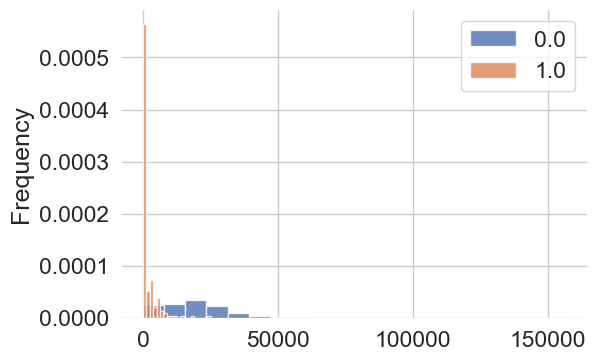

In [7]:
lalonde_nonexp.groupby('treatment')['RE75'].plot.hist(bins = 20, alpha = 0.8, density = True, legend = True)

## Causal Estimation: Partially Linear Regression

We will first estimate the Average Treatment Effect (ATE) of the training on earnings using a partially linear regression model.

In [8]:
import doubleml as dml

### Data Backend

In [9]:
x_cols = lalonde_exp.columns.drop(['RE78', 'treatment']).to_list()

dml_data_nonexp = dml.DoubleMLData(lalonde_nonexp, y_col='RE78',
                          d_cols='treatment',
                          x_cols=x_cols)

In [10]:

dml_data_exp = dml.DoubleMLData(lalonde_exp, y_col='RE78',
                          d_cols='treatment',
                          x_cols=x_cols)

In [11]:
dml_data_restricted = dml.DoubleMLData(lalonde_restricted, y_col='RE78',
                          d_cols='treatment',
                          x_cols=x_cols)

### Initialize Learners and Causal Models

We use the same specification for the learners as in @veitch2020.

In [12]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

N_EST = 100
MAX_DEPTH = 5

ml_m = RandomForestClassifier(
            random_state=42, n_estimators=N_EST, max_depth=MAX_DEPTH)

ml_g = RandomForestRegressor(
            random_state=42, n_estimators=N_EST, max_depth=MAX_DEPTH)

In [13]:
import numpy as np
np.random.seed(123)
dml_plr_nonexp = dml.DoubleMLPLR(dml_data_nonexp, ml_g, ml_m, n_folds = 10)
dml_plr_nonexp.fit()

In [14]:
np.random.seed(123)
dml_plr_exp = dml.DoubleMLPLR(dml_data_exp, ml_g, ml_m, n_folds = 10)
dml_plr_exp.fit()

In [15]:
np.random.seed(123)
dml_plr_restricted = dml.DoubleMLPLR(dml_data_restricted, ml_g, ml_m, n_folds = 10)
dml_plr_restricted.fit()

Let us summarize the input in a table.

In [16]:
results_plr_df = pd.concat([dml_plr_nonexp.summary, dml_plr_exp.summary, dml_plr_restricted.summary], keys = ["Non-experimental", "Experimental", "Restricted"])
results_plr_df.round(3)

,,coef,std err,t,P>|t|,2.5 %,97.5 %
Non-experimental,treatment,-745.933,976.957,-0.764,0.445,-2660.735,1168.868
Experimental,treatment,1726.899,677.070,2.551,0.011,399.867,3053.932
Restricted,treatment,2283.652,1029.706,2.218,0.027,265.466,4301.838


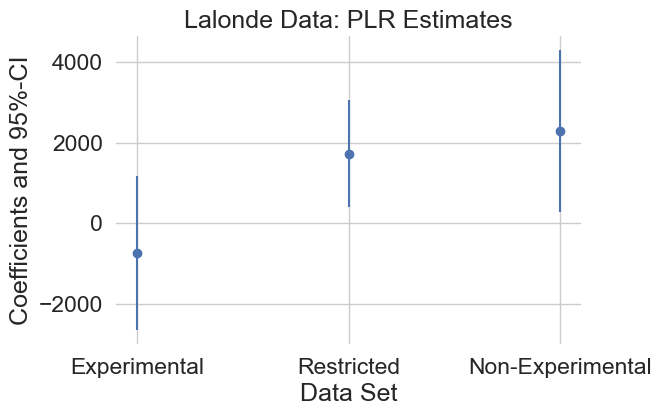

In [17]:
errors = np.full((2, results_plr_df.shape[0]), np.nan)
errors[0, :] = results_plr_df['coef'] - results_plr_df['2.5 %']
errors[1, :] = results_plr_df['97.5 %'] - results_plr_df['coef']

plt.errorbar(['Experimental', 'Restricted', 'Non-Experimental'], results_plr_df.coef, fmt='o', yerr=errors)
plt.title('Lalonde Data: PLR Estimates')
plt.ylabel('Coefficients and 95%-CI')

_ = plt.xlabel('Data Set')

## Sensitivity Analysis: Partially Linear Regression

Now let's perform some sensitivity analysis for the different samples. We start with the observational sample.

General setting: No particular $H_0$ provided.

In [18]:
dml_plr_nonexp.sensitivity_analysis()
print(dml_plr_nonexp.sensitivity_summary)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.03; cf_d=0.03, rho=1.0

------------------ Bounds with CI    ------------------
              CI lower  theta lower      theta  theta upper     CI upper
treatment -4432.348492 -2808.170373 -745.93347  1316.303432  2932.463908

------------------ Robustness Values ------------------
           H_0    RV (%)   RVa (%)
treatment  0.0  1.095868  0.000517


#### Benchmarking

Let us replicate the benchmark analysis from Imbens (2003) and Veitch and Zaveri (2020). We consider the benchmarking scenario of leaving out the variables `RE75` *and* `pos75`.^[*Note*: In Imbens (2003) and Veitch and Zaveri (2020), a fixed confounding scenario with a bias of $1000\$$ is considered. However, we will focus on the use of contour plots to visualize our results. It is basically also possible to specify such a null hypothesis through the argument `null_hypothesis` in `sensitivity_analysis()`.]

It is basically also possible to specify alternativ benchmarking scenarios when calling `sensitivity_benchmark()`.

In [19]:
bench_set = ['RE75', 'pos75']

bench_results_nonexp = dml_plr_nonexp.sensitivity_benchmark(bench_set)
print(bench_results_nonexp)

               cf_y      cf_d       rho  delta_theta
treatment  0.116983  0.062817 -0.301984 -1700.031303


*Note*: You could also experiment with other benchmarking scenarios, for example, dropping all variables on previous income together or leaving them out variable by variable. We stick to the single scenario considered above to save computation time

#### Visualization: Contour Plot

Let us visualize the results in a contour plot. Note that the results shown in the contour plot are conservative in the sense that the parameter $\rho$ is set to a value of $1$. Using lower values of $\rho$ would lead to less conservative results. However it is tricky to combine multiple values of $\rho$ in the same contour plot as it operates as a scaling factor for the bias.

In [20]:
benchmarks_dict = {'cf_d' : bench_results_nonexp['cf_d'].astype(float).round(3).tolist(),
                   'cf_y' : bench_results_nonexp['cf_y'].astype(float).round(3).tolist(),
                   'name' : ['RE75, pos75']}

contour_nonexp = dml_plr_nonexp.sensitivity_plot(grid_bounds = (0.2, 0.2), benchmarks = benchmarks_dict)
contour_nonexp.show()

### Re-examining the Analysis: Experimental and Restricted Observational Sample

### Sensitivity Analysis and Benchmarking

Experimental sample.

In [21]:
# Sensitivity analysis for experimental sample
dml_plr_exp.sensitivity_analysis()
print(dml_plr_exp.sensitivity_summary)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.03; cf_d=0.03, rho=1.0

------------------ Bounds with CI    ------------------
             CI lower  theta lower       theta  theta upper     CI upper
treatment  169.541845  1309.011131  1726.89944  2144.787748  3235.412501

------------------ Robustness Values ------------------
           H_0     RV (%)   RVa (%)
treatment  0.0  11.820295  4.117965


In [22]:
bench_results_exp = dml_plr_exp.sensitivity_benchmark(bench_set)
print(bench_results_exp)

benchmarks_dict = {'cf_d' : bench_results_exp['cf_d'].astype(float).round(3).tolist(),
                   'cf_y' : bench_results_exp['cf_y'].astype(float).round(3).tolist(),
                   'name' : ['RE75, pos75']}


contour_exp = dml_plr_exp.sensitivity_plot(grid_bounds = (0.2, 0.2), benchmarks = benchmarks_dict)
contour_exp.show()




               cf_y      cf_d       rho  delta_theta
treatment  0.010986  0.015348 -0.515442   -91.123217


Restriced non-experimental sample

In [23]:
# Sensitivity analysis for restricted sample
dml_plr_restricted.sensitivity_analysis()
print(dml_plr_restricted.sensitivity_summary)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.03; cf_d=0.03, rho=1.0

------------------ Bounds with CI    ------------------
             CI lower  theta lower       theta  theta upper     CI upper
treatment -223.933549   1487.96296  2283.65209  3079.341221  4770.699752

------------------ Robustness Values ------------------
           H_0    RV (%)   RVa (%)
treatment  0.0  8.368444  2.189394


In [24]:
bench_results_restricted = dml_plr_restricted.sensitivity_benchmark(bench_set)
print(bench_results_restricted)


benchmarks_dict = {'cf_d' : bench_results_restricted['cf_d'].astype(float).round(3).tolist(),
                   'cf_y' : bench_results_restricted['cf_y'].astype(float).round(3).tolist(),
                   'name' : ['RE75, pos75']}



contour_restricted = dml_plr_restricted.sensitivity_plot(grid_bounds = (0.2, 0.2), benchmarks = benchmarks_dict)
contour_restricted.show()


               cf_y     cf_d       rho  delta_theta
treatment  0.017975  0.03555 -0.732761  -475.482524


It is basically possible to perform the causal estimation and sensitivity analysis in the Lalonde data example with the IRM model. The steps of the analysis are very much identical, so we hope you could try this on your own. In case you have any questions, feel free to contact us :)

## References

- Huber, Martin. 2023. *Causal Analysis: Impact Evaluation and Causal Machine Learning with Applications in r*. MIT Press.
- Imbens, Guido W. 2003. “Sensitivity to Exogeneity Assumptions in Program Evaluation.” American Economic Review 93 (2): 126–32.
- Veitch, Victor, and Anisha Zaveri. 2020. “Sense and Sensitivity Analysis: Simple Post-Hoc Analysis of Bias Due to Unobserved Confounding.” Advances in Neural Information Processing Systems 33: 10999–1009.
